In [2]:
import pandas as pd 
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

In [3]:
dim_reduced_df = pd.read_csv('../data/feature-engineered/df_2_reduced.csv')

In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Financial indicators to forecast
financial_indicators = [
    '1_year_rate', '3_months_rate', '6_months_rate', 'CPI', 'INDPRO', 
    '10_year_rate', 'share_price', 'unemployment_rate', 'PPI', 
    'OECD_CLI_index', 'CSI_index', 'gdp_per_capita'
]

# Recession probability target columns to exclude from exog
recession_targets = [
    'recession_probability', '1_month_recession_probability', 
    '3_month_recession_probability', '6_month_recession_probability'
]

def prepare_data_split(df, date_col='date', split_year=2020):
    df[date_col] = pd.to_datetime(df[date_col])
    df_sorted = df.sort_values(date_col).reset_index(drop=True)
    train_data = df_sorted[df_sorted[date_col].dt.year < split_year].copy()
    test_data = df_sorted[df_sorted[date_col].dt.year >= split_year].copy()
    print(f"Training data: {len(train_data)} observations ({train_data[date_col].min()} to {train_data[date_col].max()})")
    print(f"Test data: {len(test_data)} observations ({test_data[date_col].min()} to {test_data[date_col].max()})")
    return train_data, test_data

def check_stationarity(series, series_name):
    result = adfuller(series.dropna())
    print(f'\n{series_name} Stationarity Test:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    if result[1] <= 0.05:
        print("Series is stationary")
        return True
    else:
        print("Series is non-stationary")
        return False

def auto_arima_with_exog(series, exog, max_p=3, max_d=2, max_q=3):
    best_aic = float('inf')
    best_order = None
    best_model = None

    # Clean exog
    exog = exog.fillna(method='ffill').fillna(method='bfill')
    exog = exog.replace([np.inf, -np.inf], np.nan)
    exog = exog.fillna(method='ffill').fillna(method='bfill')
    exog = exog.loc[:, exog.nunique() > 1]  # Remove constant columns
    
    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    print(f"Trying ARIMA order: ({p},{d},{q})")
                    model = ARIMA(series, order=(p, d, q), exog=exog, trend='n')  # No constant trend
                    fitted_model = model.fit()
                    print(f"  Success: AIC = {fitted_model.aic}")
                    if fitted_model.aic < best_aic:
                        best_aic = fitted_model.aic
                        best_order = (p, d, q)
                        best_model = fitted_model
                except Exception as e:
                    print(f"  Failed ARIMA order ({p},{d},{q}): {e}")
                    continue

    return best_model, best_order, best_aic


def forecast_indicator_with_exog(train_df, test_df, indicator_name, forecast_steps=None):
    print(f"\n{'='*50}")
    print(f"Forecasting: {indicator_name}")
    print(f"{'='*50}")

    train_series = train_df[indicator_name].dropna()
    test_series = test_df[indicator_name].dropna()

    # Prepare exogenous variables: exclude target columns and the indicator itself
    features_to_exclude = recession_targets + financial_indicators
    train_exog = train_df.drop(columns=features_to_exclude, errors='ignore')
    test_exog = test_df.drop(columns=features_to_exclude, errors='ignore')

    # Align exog and endog indices
    train_exog = train_exog.loc[train_series.index]
    test_exog = test_exog.loc[test_series.index]

    # Clean exog
    train_exog = train_exog.fillna(method='ffill').fillna(method='bfill')
    train_exog = train_exog.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')
    train_exog = train_exog.loc[:, train_exog.nunique() > 1]  # Remove constant columns

    test_exog = test_exog.fillna(method='ffill').fillna(method='bfill')
    test_exog = test_exog.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')

    # Ensure test_exog columns are exactly the same as train_exog columns, in the same order
    test_exog = test_exog[train_exog.columns]

    # Now set forecast_steps properly
    if forecast_steps is None:
        forecast_steps = min(len(test_series), len(test_exog))

    # Stationarity test
    check_stationarity(train_series, indicator_name)

    # Fit ARIMA
    try:
        model, order, aic = auto_arima_with_exog(train_series, train_exog)
        print(f"Best ARIMA order: {order}")
        print(f"AIC: {aic:.2f}")

        forecast_result = model.forecast(steps=forecast_steps, exog=test_exog.iloc[:forecast_steps])
        forecast_ci = model.get_forecast(steps=forecast_steps, exog=test_exog.iloc[:forecast_steps]).conf_int()

        results = {
            'model': model,
            'order': order,
            'aic': aic,
            'forecast': forecast_result,
            'forecast_lower': forecast_ci.iloc[:, 0],
            'forecast_upper': forecast_ci.iloc[:, 1],
            'actual': test_series.iloc[:forecast_steps]
        }

        actual_values = test_series.iloc[:forecast_steps]
        mae = np.mean(np.abs(forecast_result - actual_values))
        rmse = np.sqrt(np.mean((forecast_result - actual_values) ** 2))
        mape = np.mean(np.abs((actual_values - forecast_result) / actual_values)) * 100

        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAPE: {mape:.2f}%")

        results.update({'mae': mae, 'rmse': rmse, 'mape': mape})

        return results

    except Exception as e:
        print(f"Error fitting ARIMA for {indicator_name}: {str(e)}")
        return None



def plot_forecast_results(results, indicator_name, train_series, test_dates):
    if results is None:
        return
    
    plt.figure(figsize=(12, 6))
    train_plot = train_series.tail(24)
    plt.plot(train_plot.index, train_plot.values, label='Training Data', color='blue')
    
    actual = results['actual']
    forecast_dates = test_dates[:len(actual)]
    plt.plot(forecast_dates, actual.values, label='Actual', color='green', linewidth=2)
    
    forecast = results['forecast']
    forecast_dates_full = test_dates[:len(forecast)]
    plt.plot(forecast_dates_full, forecast, label='Forecast', color='red', linewidth=2)
    
    plt.fill_between(forecast_dates_full, 
                     results['forecast_lower'], 
                     results['forecast_upper'], 
                     alpha=0.3, color='red', label='95% Confidence Interval')
    
    plt.title(f'{indicator_name} - ARIMA Forecast with Exogenous Variables')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def run_time_series_forecasting(df, financial_indicators, plot_results=True):
    train_data, test_data = prepare_data_split(df)
    
    all_results = {}
    forecasted_values = pd.DataFrame()
    forecasted_values['date'] = test_data['date'].reset_index(drop=True)
    
    for indicator in financial_indicators:
        if indicator not in df.columns:
            print(f"Warning: {indicator} not found in dataframe")
            continue
        
        results = forecast_indicator_with_exog(train_data.set_index('date'), test_data.set_index('date'), indicator)
        
        if results is not None:
            # Align forecasts to the test index length
            forecast_series = pd.Series(
                results['forecast'].values,
                index=test_data['date'][:len(results['forecast'])].values
            )
            lower_series = pd.Series(
                results['forecast_lower'].values,
                index=test_data['date'][:len(results['forecast_lower'])].values
            )
            upper_series = pd.Series(
                results['forecast_upper'].values,
                index=test_data['date'][:len(results['forecast_upper'])].values
            )

            # Ensure forecasted_values also uses the same date index
            forecasted_values.set_index('date', inplace=True)

            forecasted_values.loc[forecast_series.index, f'{indicator}_forecast'] = forecast_series.values
            forecasted_values.loc[lower_series.index, f'{indicator}_lower'] = lower_series.values
            forecasted_values.loc[upper_series.index, f'{indicator}_upper'] = upper_series.values

            forecasted_values.reset_index(inplace=True)


            # Save results
            all_results[indicator] = results

            # Plot if requested
            if plot_results:
                plot_forecast_results(
                    results,
                    indicator,
                    train_data.set_index('date')[indicator],
                    test_data['date']
                )
    
    return all_results, forecasted_values, train_data, test_data


Training data: 635 observations (1967-02-01 00:00:00 to 2019-12-01 00:00:00)
Test data: 65 observations (2020-01-01 00:00:00 to 2025-05-01 00:00:00)

Forecasting: 1_year_rate

1_year_rate Stationarity Test:
ADF Statistic: -1.464638
p-value: 0.550926
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 2521.7478476331994
Trying ARIMA order: (0,0,1)
  Success: AIC = 1919.3054860478246
Trying ARIMA order: (0,0,2)
  Success: AIC = 1764.2358848513747
Trying ARIMA order: (0,0,3)
  Success: AIC = 1612.1262390538586
Trying ARIMA order: (0,1,0)
  Success: AIC = 454.67689657770563
Trying ARIMA order: (0,1,1)
  Success: AIC = 403.458284257595
Trying ARIMA order: (0,1,2)
  Success: AIC = 399.1283891998894
Trying ARIMA order: (0,1,3)
  Success: AIC = 403.37225749825313
Trying ARIMA order: (0,2,0)
  Success: AIC = 636.8608184392282
Trying ARIMA order: (0,2,1)
  Success: AIC = 526.6744425169591
Trying ARIMA order: (0,2,2)
  Success: AIC = 474.61373844315085
Trying ARIMA order: (0,2,3

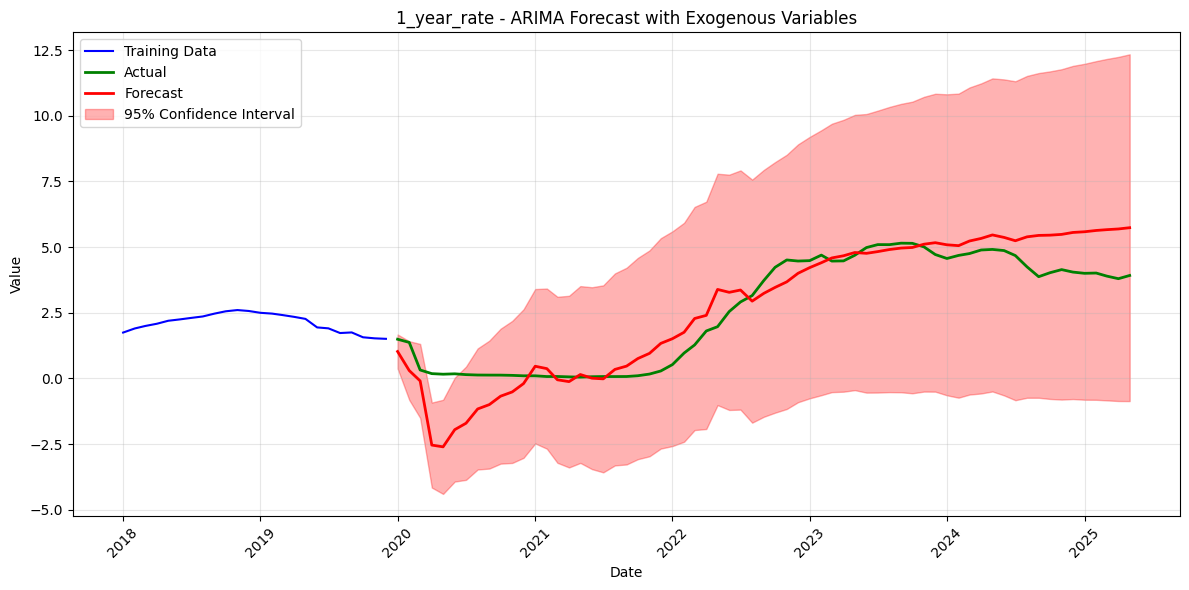


Forecasting: 3_months_rate

3_months_rate Stationarity Test:
ADF Statistic: -1.869398
p-value: 0.346591
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 2682.889173164497
Trying ARIMA order: (0,0,1)
  Success: AIC = 2329.2146381668485
Trying ARIMA order: (0,0,2)
  Success: AIC = 2037.341268814003
Trying ARIMA order: (0,0,3)
  Success: AIC = 1904.0175018370207
Trying ARIMA order: (0,1,0)
  Success: AIC = 654.3905231193012
Trying ARIMA order: (0,1,1)
  Success: AIC = 596.2189258006459
Trying ARIMA order: (0,1,2)
  Success: AIC = 592.8249088255105
Trying ARIMA order: (0,1,3)
  Success: AIC = 596.6087433696572
Trying ARIMA order: (0,2,0)
  Success: AIC = 874.2470902779652
Trying ARIMA order: (0,2,1)
  Success: AIC = 697.3605472006416
Trying ARIMA order: (0,2,2)
  Success: AIC = 636.9999754661874
Trying ARIMA order: (0,2,3)
  Success: AIC = 644.8246411005604
Trying ARIMA order: (1,0,0)
  Success: AIC = 1232.2261899326318
Trying ARIMA order: (1,0,1)
  Success: AIC = 122

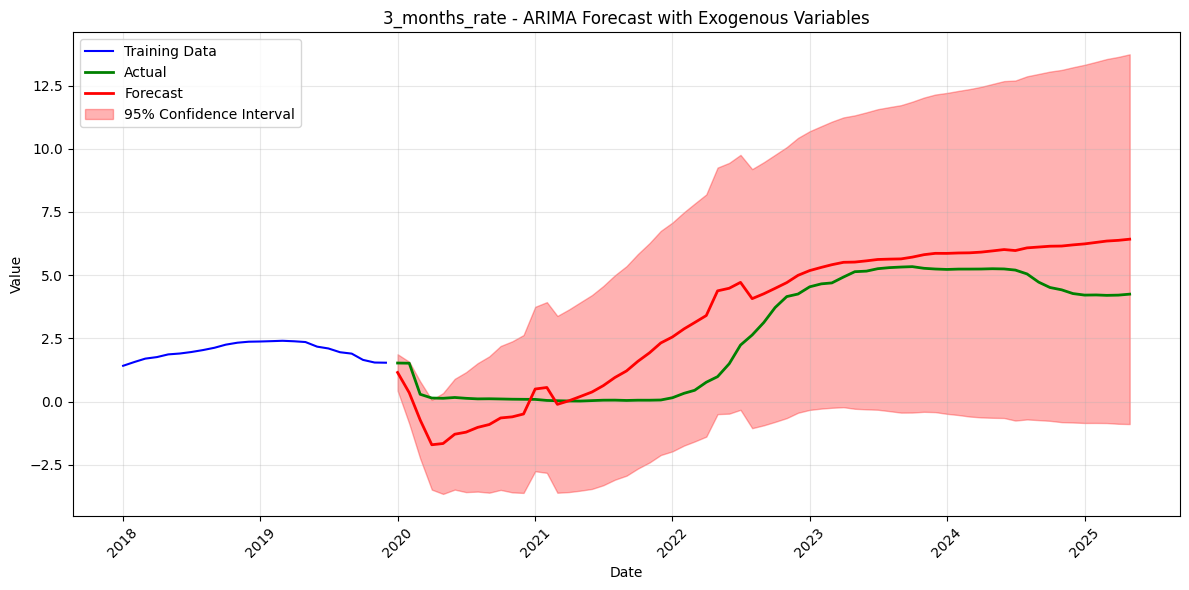


Forecasting: 6_months_rate

6_months_rate Stationarity Test:
ADF Statistic: -1.740531
p-value: 0.410360
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 2927.0047829277505
Trying ARIMA order: (0,0,1)
  Success: AIC = 2301.42464354194
Trying ARIMA order: (0,0,2)
  Success: AIC = 1960.2948633084372
Trying ARIMA order: (0,0,3)
  Success: AIC = 1882.640659676717
Trying ARIMA order: (0,1,0)
  Success: AIC = 570.3229028165522
Trying ARIMA order: (0,1,1)
  Success: AIC = 515.0880390558723
Trying ARIMA order: (0,1,2)
  Success: AIC = 513.9926586689514
Trying ARIMA order: (0,1,3)
  Success: AIC = 517.5206287757514
Trying ARIMA order: (0,2,0)
  Success: AIC = 785.2897163435076
Trying ARIMA order: (0,2,1)
  Success: AIC = 625.6907999664228
Trying ARIMA order: (0,2,2)
  Success: AIC = 567.642708294625
Trying ARIMA order: (0,2,3)
  Success: AIC = 578.7707345769837
Trying ARIMA order: (1,0,0)
  Success: AIC = 1151.1587718417284
Trying ARIMA order: (1,0,1)
  Success: AIC = 1076.

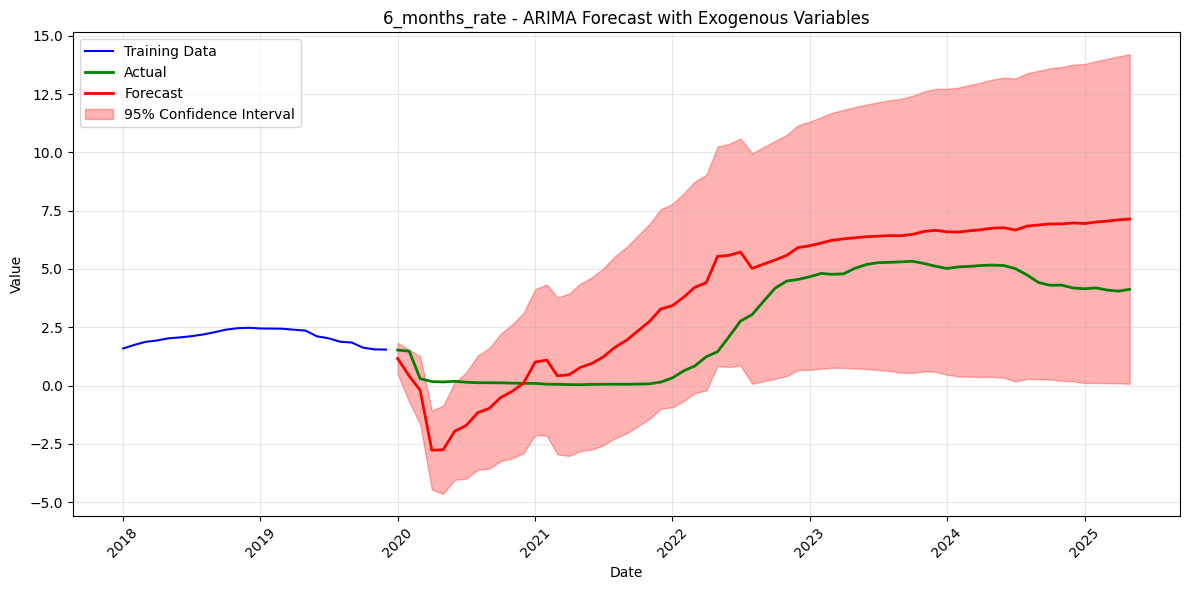


Forecasting: CPI

CPI Stationarity Test:
ADF Statistic: 0.230335
p-value: 0.973913
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 3188.7674176691444
Trying ARIMA order: (0,0,1)
  Success: AIC = -300.9522260463059
Trying ARIMA order: (0,0,2)
  Success: AIC = -299.09953361503636
Trying ARIMA order: (0,0,3)
  Success: AIC = -291.27671292807105
Trying ARIMA order: (0,1,0)
  Success: AIC = -93.35591886066794
Trying ARIMA order: (0,1,1)
  Success: AIC = -145.28175320463092
Trying ARIMA order: (0,1,2)
  Success: AIC = -188.22630314446715
Trying ARIMA order: (0,1,3)
  Success: AIC = -210.32116119912797
Trying ARIMA order: (0,2,0)
  Success: AIC = 358.99894362747693
Trying ARIMA order: (0,2,1)
  Success: AIC = -41.3292250176695
Trying ARIMA order: (0,2,2)
  Success: AIC = 6.763417594285215
Trying ARIMA order: (0,2,3)
  Success: AIC = -28.788334761053363
Trying ARIMA order: (1,0,0)
  Success: AIC = -298.6587538720137
Trying ARIMA order: (1,0,1)
  Success: AIC = -298.99275

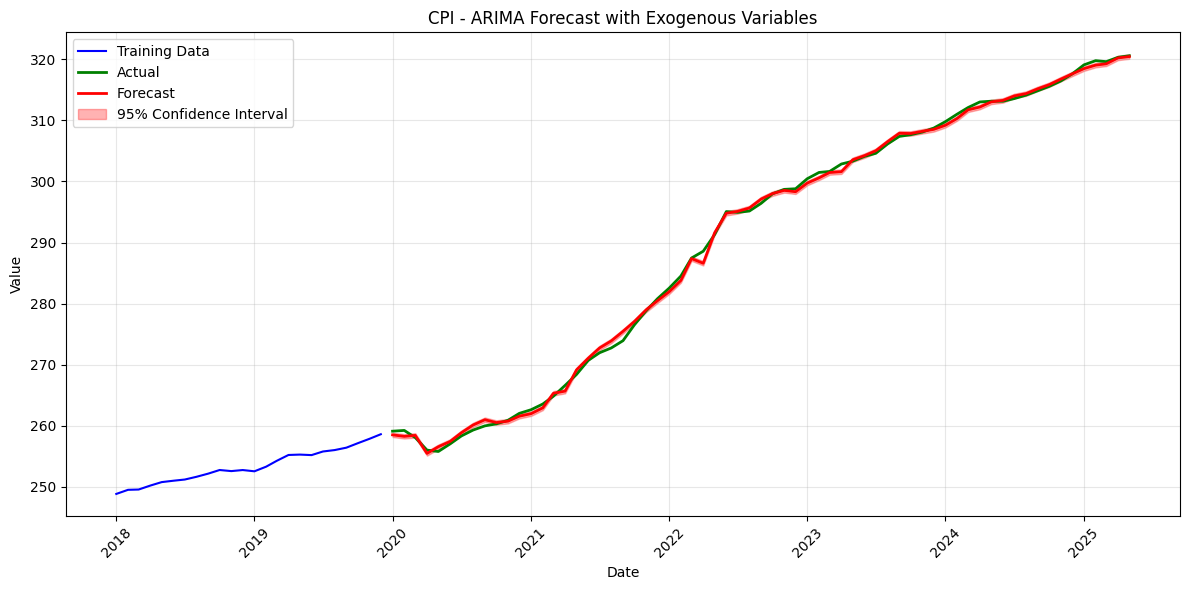


Forecasting: INDPRO

INDPRO Stationarity Test:
ADF Statistic: -0.970779
p-value: 0.763772
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 3299.69683249875
Trying ARIMA order: (0,0,1)
  Success: AIC = -232.49747972794592
Trying ARIMA order: (0,0,2)
  Success: AIC = -244.63722937063693
Trying ARIMA order: (0,0,3)
  Success: AIC = -213.46157166286355
Trying ARIMA order: (0,1,0)
  Success: AIC = -78.198894167482
Trying ARIMA order: (0,1,1)
  Success: AIC = -138.31072772421703
Trying ARIMA order: (0,1,2)
  Success: AIC = -136.89272714193632
Trying ARIMA order: (0,1,3)
  Success: AIC = -146.29452742174857
Trying ARIMA order: (0,2,0)
  Success: AIC = 491.22995078941597
Trying ARIMA order: (0,2,1)
  Success: AIC = -7.894418742848103
Trying ARIMA order: (0,2,2)
  Success: AIC = 2.7736561116173277
Trying ARIMA order: (0,2,3)
  Success: AIC = 14.430113962852346
Trying ARIMA order: (1,0,0)
  Success: AIC = -249.1939637443885
Trying ARIMA order: (1,0,1)
  Success: AIC = -247.

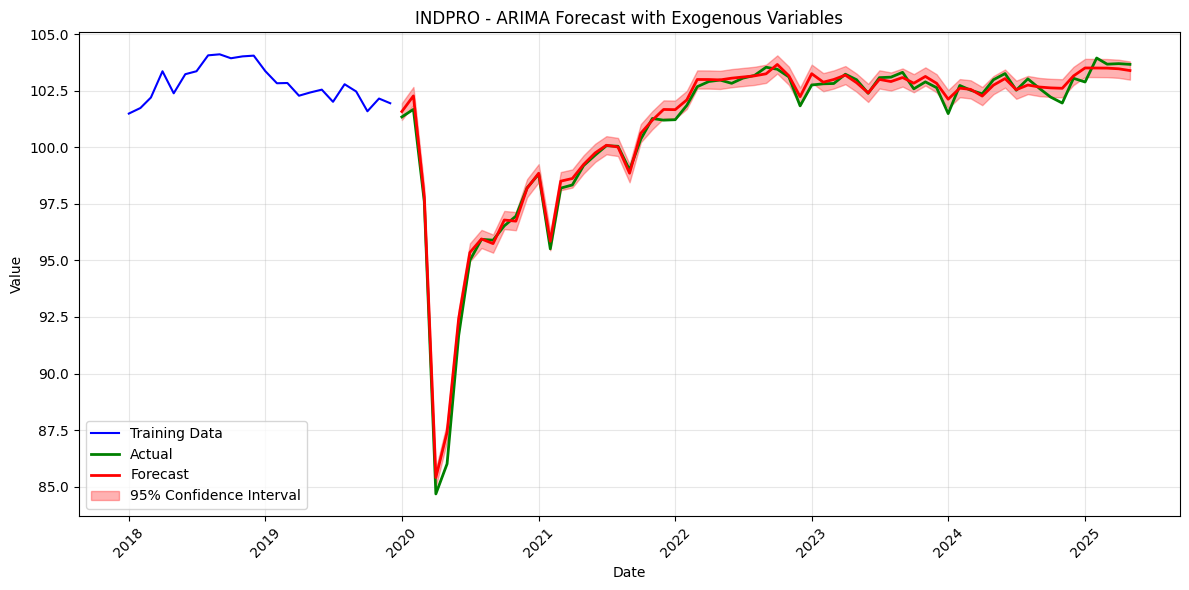


Forecasting: 10_year_rate

10_year_rate Stationarity Test:
ADF Statistic: -0.897583
p-value: 0.788767
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 2785.6330461369976
Trying ARIMA order: (0,0,1)
  Success: AIC = 2011.9627997368077
Trying ARIMA order: (0,0,2)
  Success: AIC = 1725.1627501191538
Trying ARIMA order: (0,0,3)
  Success: AIC = 1586.701367527513
Trying ARIMA order: (0,1,0)
  Success: AIC = 201.31721821047955
Trying ARIMA order: (0,1,1)
  Success: AIC = 151.0156633213931
Trying ARIMA order: (0,1,2)
  Success: AIC = 143.8967307102817
Trying ARIMA order: (0,1,3)
  Success: AIC = 146.27747474887582
Trying ARIMA order: (0,2,0)
  Success: AIC = 453.3566093754711
Trying ARIMA order: (0,2,1)
  Success: AIC = 254.09392996793073
Trying ARIMA order: (0,2,2)
  Success: AIC = 203.51544336753938
Trying ARIMA order: (0,2,3)
  Success: AIC = 196.07617357132557
Trying ARIMA order: (1,0,0)
  Success: AIC = 761.6567755010244
Trying ARIMA order: (1,0,1)
  Success: AIC = 

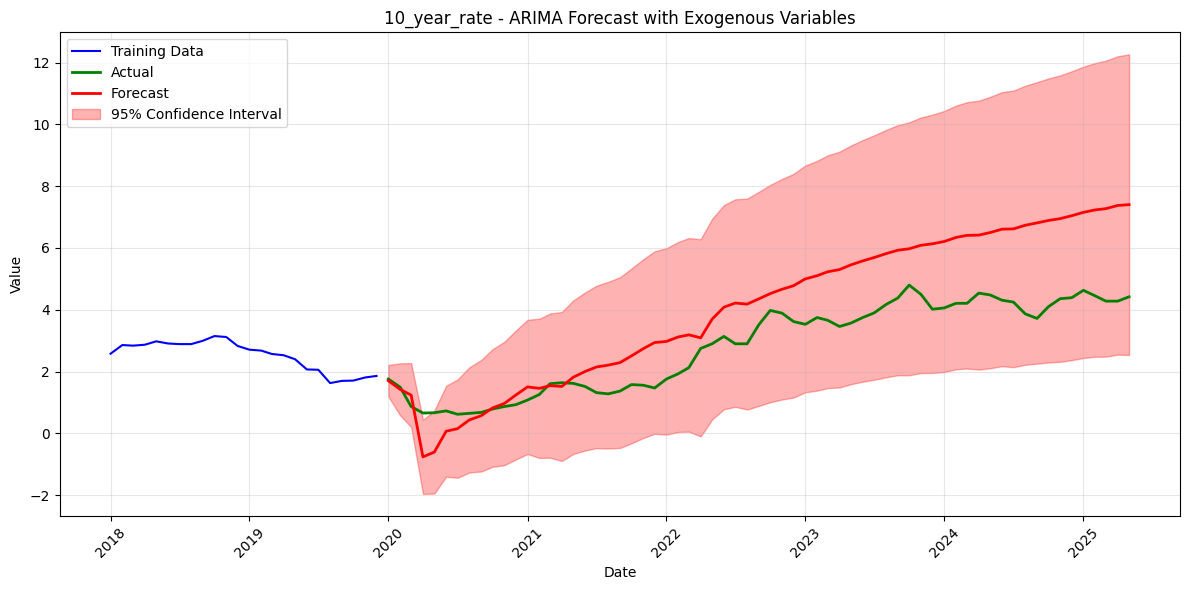


Forecasting: share_price

share_price Stationarity Test:
ADF Statistic: -0.059505
p-value: 0.953326
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 3075.696885338805
Trying ARIMA order: (0,0,1)
  Success: AIC = -653.9111788666198
Trying ARIMA order: (0,0,2)
  Success: AIC = -941.2846349648163
Trying ARIMA order: (0,0,3)
  Success: AIC = -986.4030593389846
Trying ARIMA order: (0,1,0)
  Success: AIC = -1989.807484947692
Trying ARIMA order: (0,1,1)
  Success: AIC = -2013.5242812869155
Trying ARIMA order: (0,1,2)
  Success: AIC = -2018.8356454962168
Trying ARIMA order: (0,1,3)
  Success: AIC = -2016.640713026512
Trying ARIMA order: (0,2,0)
  Success: AIC = -1703.5207194019163
Trying ARIMA order: (0,2,1)
  Success: AIC = -1849.9603308952805
Trying ARIMA order: (0,2,2)
  Success: AIC = -1910.4932543928903
Trying ARIMA order: (0,2,3)
  Success: AIC = -1912.079858673157
Trying ARIMA order: (1,0,0)
  Success: AIC = -1901.7984899367934
Trying ARIMA order: (1,0,1)
  Success

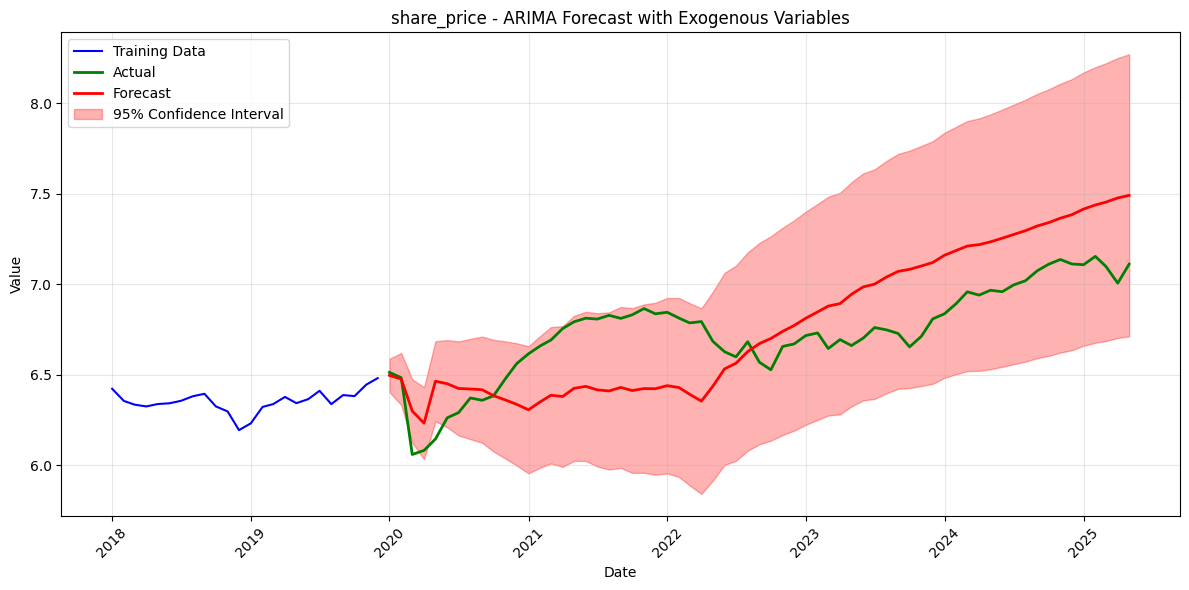


Forecasting: unemployment_rate

unemployment_rate Stationarity Test:
ADF Statistic: -3.046251
p-value: 0.030795
Series is stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 2028.495886840061
Trying ARIMA order: (0,0,1)
  Success: AIC = -1500.2928256232342
Trying ARIMA order: (0,0,2)
  Success: AIC = -1504.7398532068166
Trying ARIMA order: (0,0,3)
  Success: AIC = -1498.8879069024206
Trying ARIMA order: (0,1,0)
  Success: AIC = -1305.8270985579256
Trying ARIMA order: (0,1,1)
  Success: AIC = -1384.198648888415
Trying ARIMA order: (0,1,2)
  Success: AIC = -1406.55658645006
Trying ARIMA order: (0,1,3)
  Success: AIC = -1423.8009629712237
Trying ARIMA order: (0,2,0)
  Success: AIC = -722.2087585310285
Trying ARIMA order: (0,2,1)
  Success: AIC = -1247.0797633132677
Trying ARIMA order: (0,2,2)
  Success: AIC = -1290.2840550176834
Trying ARIMA order: (0,2,3)
  Success: AIC = -1302.3649937958576
Trying ARIMA order: (1,0,0)
  Success: AIC = -1505.313836216114
Trying ARIMA order: (1,0,1)


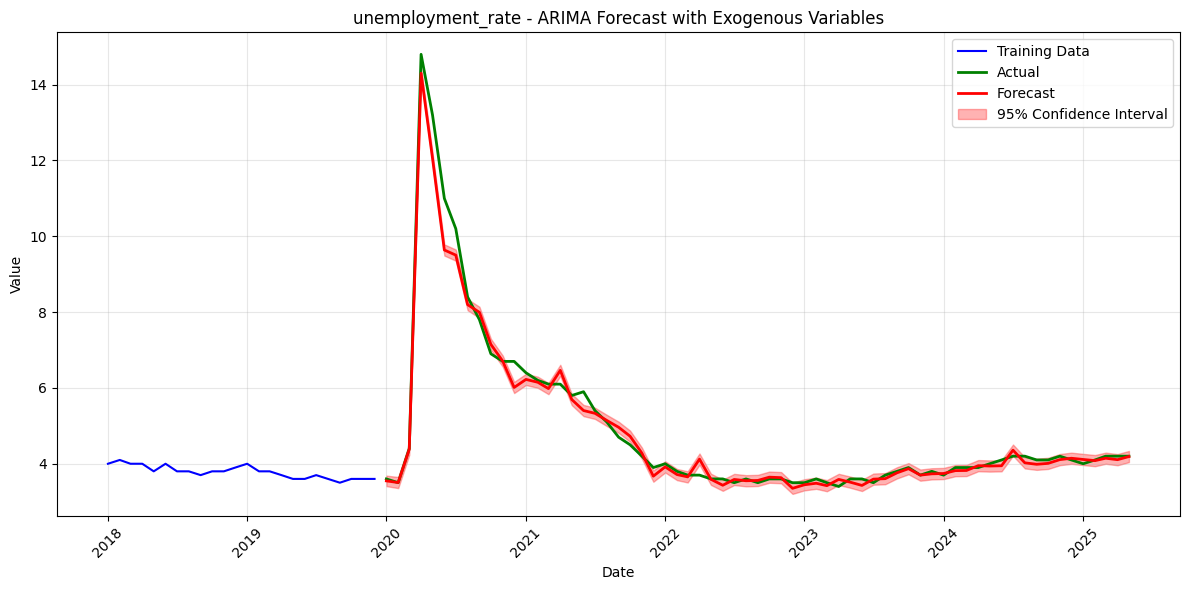


Forecasting: PPI

PPI Stationarity Test:
ADF Statistic: 0.191008
p-value: 0.971753
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 3398.6457073425736
Trying ARIMA order: (0,0,1)
  Success: AIC = 3023.0338131179124
Trying ARIMA order: (0,0,2)
  Success: AIC = 2930.922856834782
Trying ARIMA order: (0,0,3)
  Success: AIC = 2915.0207875188444
Trying ARIMA order: (0,1,0)
  Success: AIC = 2887.1744891371445
Trying ARIMA order: (0,1,1)
  Success: AIC = 2863.744789425149
Trying ARIMA order: (0,1,2)
  Success: AIC = 2831.8544018926245
Trying ARIMA order: (0,1,3)
  Success: AIC = 2833.214258127643
Trying ARIMA order: (0,2,0)
  Success: AIC = 3021.6362540606924
Trying ARIMA order: (0,2,1)
  Success: AIC = 2939.2703844943517
Trying ARIMA order: (0,2,2)
  Success: AIC = 2941.1784503196473
Trying ARIMA order: (0,2,3)
  Success: AIC = 2860.329769511104
Trying ARIMA order: (1,0,0)
  Success: AIC = 2858.6501295134944
Trying ARIMA order: (1,0,1)
  Success: AIC = 2869.471464143917


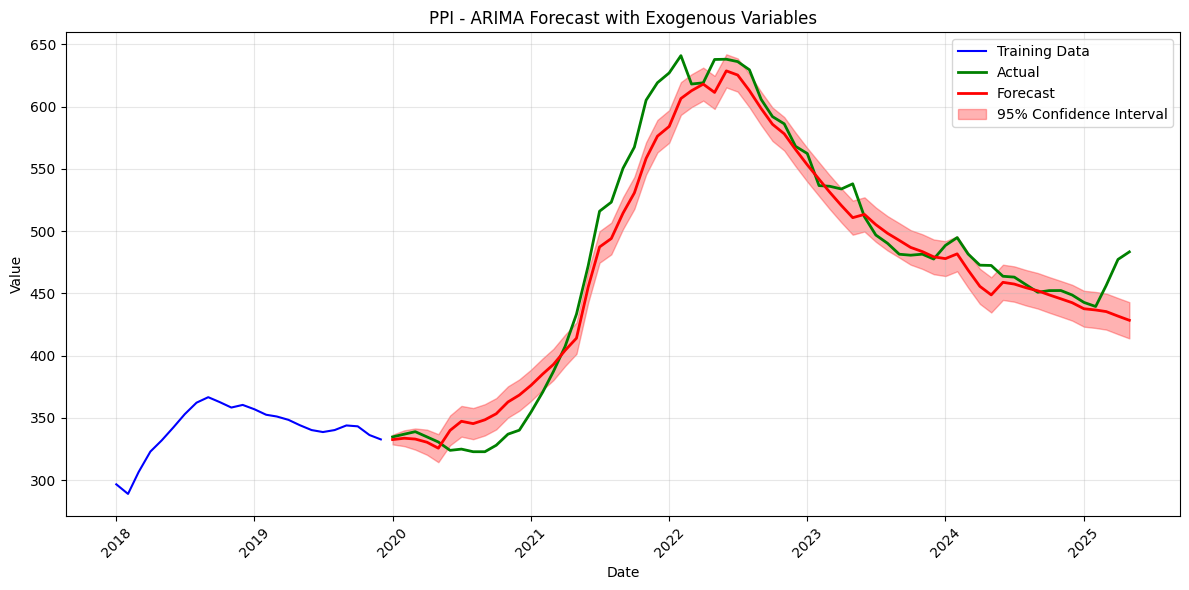


Forecasting: OECD_CLI_index

OECD_CLI_index Stationarity Test:
ADF Statistic: -6.053841
p-value: 0.000000
Series is stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 2478.623215986673
Trying ARIMA order: (0,0,1)
  Success: AIC = 1275.1069843216546
Trying ARIMA order: (0,0,2)
  Success: AIC = 1152.2276309986935
Trying ARIMA order: (0,0,3)
  Success: AIC = 1011.6925116527713
Trying ARIMA order: (0,1,0)
  Success: AIC = -351.07680861545543
Trying ARIMA order: (0,1,1)
  Success: AIC = -878.0356828464184
Trying ARIMA order: (0,1,2)
  Success: AIC = -1210.2921169133867
Trying ARIMA order: (0,1,3)
  Success: AIC = -1478.6170911398935
Trying ARIMA order: (0,2,0)
  Success: AIC = -1706.172541746688
Trying ARIMA order: (0,2,1)
  Success: AIC = -2423.996971206251
Trying ARIMA order: (0,2,2)
  Success: AIC = -2841.319377692399
Trying ARIMA order: (0,2,3)
  Success: AIC = -2943.1836335547696
Trying ARIMA order: (1,0,0)
  Success: AIC = 313.7967686113547
Trying ARIMA order: (1,0,1)
  Success:

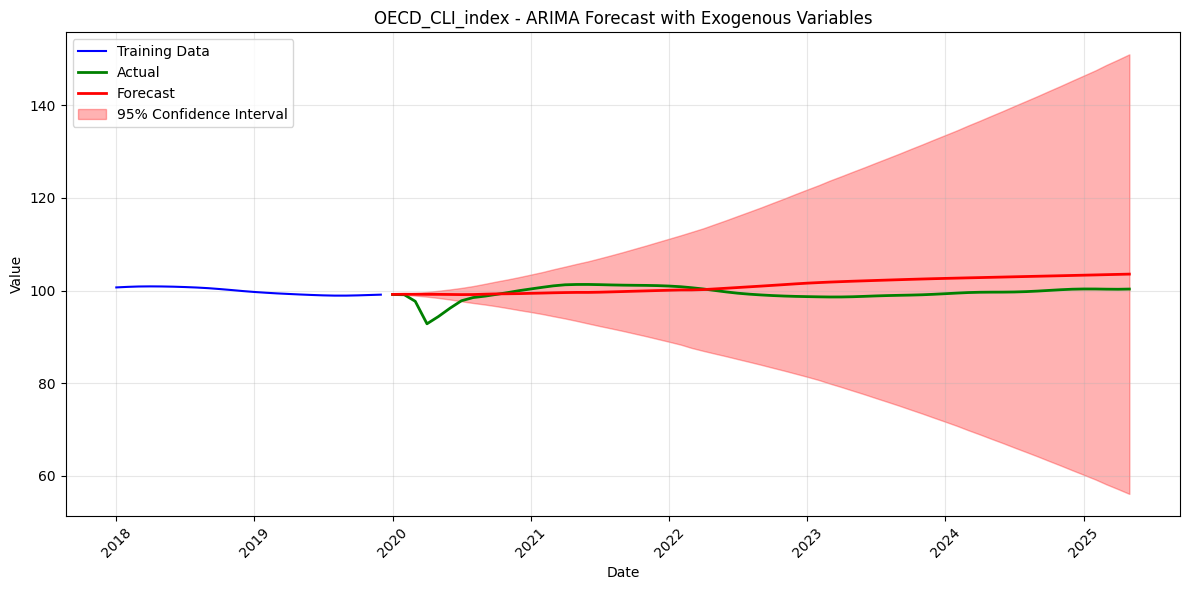


Forecasting: CSI_index

CSI_index Stationarity Test:
ADF Statistic: -3.389553
p-value: 0.011320
Series is stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 4312.52672742172
Trying ARIMA order: (0,0,1)
  Success: AIC = 3913.4260924506193
Trying ARIMA order: (0,0,2)
  Success: AIC = 3799.047249033458
Trying ARIMA order: (0,0,3)
  Success: AIC = 3753.064981861685
Trying ARIMA order: (0,1,0)
  Success: AIC = 3481.155505254566
Trying ARIMA order: (0,1,1)
  Success: AIC = 3478.4011734476094
Trying ARIMA order: (0,1,2)
  Success: AIC = 3457.9377776582246
Trying ARIMA order: (0,1,3)
  Success: AIC = 3453.616895194565
Trying ARIMA order: (0,2,0)
  Success: AIC = 3938.665075778925
Trying ARIMA order: (0,2,1)
  Success: AIC = 3487.192222228067
Trying ARIMA order: (0,2,2)
  Success: AIC = 3487.8337203123347
Trying ARIMA order: (0,2,3)
  Success: AIC = 3470.2159084965997
Trying ARIMA order: (1,0,0)
  Success: AIC = 3538.860144148087
Trying ARIMA order: (1,0,1)
  Success: AIC = 3577.473145918

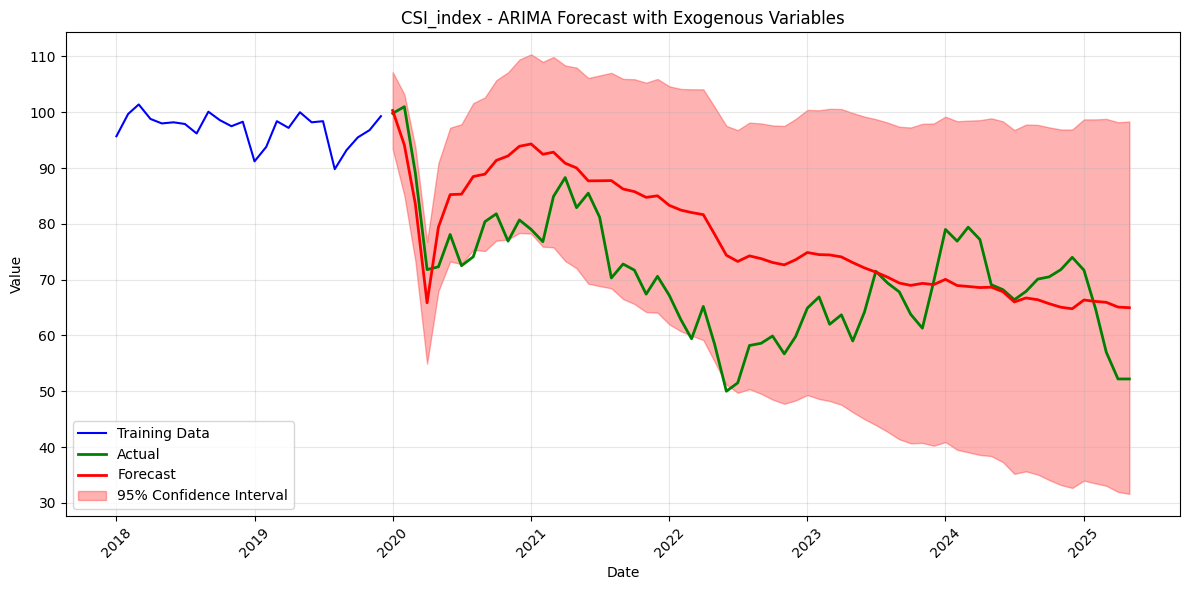


Forecasting: gdp_per_capita

gdp_per_capita Stationarity Test:
ADF Statistic: -0.060547
p-value: 0.953229
Series is non-stationary
Trying ARIMA order: (0,0,0)
  Success: AIC = 10013.826387099778
Trying ARIMA order: (0,0,1)
  Success: AIC = 9320.662973946879
Trying ARIMA order: (0,0,2)
  Success: AIC = 8999.25020504001
Trying ARIMA order: (0,0,3)
  Success: AIC = 9163.533648078484
Trying ARIMA order: (0,1,0)
  Success: AIC = 7381.849922962637
Trying ARIMA order: (0,1,1)
  Success: AIC = 7365.198251244869
Trying ARIMA order: (0,1,2)
  Success: AIC = 7360.96796801772
Trying ARIMA order: (0,1,3)
  Success: AIC = 7362.631402167794
Trying ARIMA order: (0,2,0)
  Success: AIC = 7119.073490913342
Trying ARIMA order: (0,2,1)
  Success: AIC = 7120.926150403007
Trying ARIMA order: (0,2,2)
  Success: AIC = 7121.2287185493315
Trying ARIMA order: (0,2,3)
  Success: AIC = 6981.110097095487
Trying ARIMA order: (1,0,0)
  Success: AIC = 7757.144524431838
Trying ARIMA order: (1,0,1)
  Success: AIC = 8137

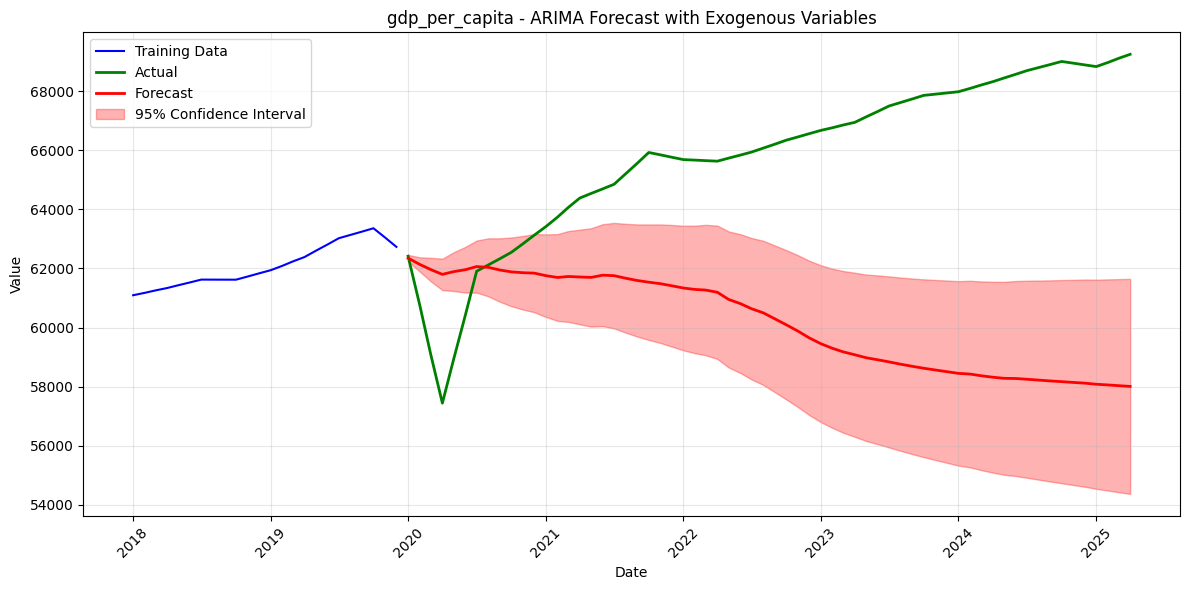

In [5]:
all_results, forecasted_values, train_data, test_data = run_time_series_forecasting(dim_reduced_df, financial_indicators)


In [6]:

# Prepare summary table
metrics_list = []

for indicator, res in all_results.items():
    metrics_list.append({
        'Indicator': indicator,
        'MAE': res['mae'],
        'RMSE': res['rmse'],
        'MAPE_%': res['mape']
    })

metrics_df = pd.DataFrame(metrics_list).set_index('Indicator')

print("\nForecast Performance Metrics:")
print(metrics_df.round(4))


Forecast Performance Metrics:
                         MAE       RMSE    MAPE_%
Indicator                                        
1_year_rate              NaN        NaN       NaN
3_months_rate         1.1677     1.4140  525.6998
6_months_rate         1.7952     2.0222  615.3320
CPI                   0.5016     0.6196    0.1766
INDPRO                0.2482     0.3423    0.2520
10_year_rate          1.3463     1.6203   49.6469
share_price           0.2584     0.2867    3.8094
unemployment_rate     0.1694     0.2953    2.9440
PPI                  15.3155    20.2511    3.2644
OECD_CLI_index        2.2257     2.5719    2.2470
CSI_index             9.8319    11.5713   14.9263
gdp_per_capita     6059.9300  7013.0541    9.0308
